# E3 - Shrinking Kernel Deconvolution

## 1. Introduction
#### Theory background
High-order SOFI provides is an estimation of the point spread function (PSF) of the optical system. With the information of PSF, we can use [deconvolution](https://en.wikipedia.org/wiki/Deconvolution) to solve the inverse problem to achieve further resolution enhancement (theoretically, $\sqrt(n)$ fold) in the SOFI image [1].

In SOFI 2.0, [shrinking kernel deconvolution (DeconvSK)](https://escholarship.org/content/qt5xs5v4qm/qt5xs5v4qm.pdf?t=oniulr) is applied on each frame of the noise filtered \textit{moment} images to to achieve further enhancement of the resolution. The idea of shrinking kernel deconvolution is that the deconvolution kernel (2D Gaussian) can be decomposed into a series of narrower Gaussian kernels. For a Gaussian kernel $U$, 

$ U^{\frac{\lambda}{\lambda-1}}*U^{\frac{\lambda^2}{\lambda-1}}*\cdots*U^{\frac{\lambda^n}{\lambda-1}}\propto U $,      --    (Eq. 1)

where $\lambda$ is an empirical parameter, $*$ represents the convolution operation, and $\propto$ represents the proportionality. In this way, each individual deconvolution step is a lighter task, because the target is more similar to the input image. In SOFI 2.0, the individual deconvolution step within the loop of *DeconvSK* is performed using the [Richard-Lucy deconvolution](https://en.wikipedia.org/wiki/Richardson%E2%80%93Lucy_deconvolution). 

#### What's included in this notebook
This notebook demonstrates how to use the shrinking kernel deconvoluiton provided in the **pysofi** package with two options. One option (section 3) is to perfrom DeconvSK through the PysofiData class and is useful when one wants to use it in the existing SOFI analysis workflow we implemented in the PysofiData class. The second option (section 4) is to use it by directly importing and using the relevant function module (deconvsk.py). This option is useful when one would like to use the shrinking kernel deconvolution as a standalone processing step in their own data analysis workflow.



#### Relevant dataset
The datafiles used in the examples (Jupyter Notebooks) are included in the *exampledata* folder in the **pysofi** repository. In this notebook, we use an experimental dataset from our previous work [1]. The sample is a Hela cell transfected with Dronpa-C12 (fluorescent protein) fused to β-Actin. Details of the experimental procedure are availble in the relevant pulbication [1]. we only used 200 frames in this demonstration ('Block10.tif') to obtain the relevant moment image. 

The input data for DeconvSK specifically can be replaced with any numpy.ndarray variable. 



## 2. Import all the tools
Before we begin, let's first import all the relevant packages and modules.

In [1]:
import sys
sys.path.append('..')
import numpy as np
import matplotlib.pyplot as plt
from functions import pysofi, masks
%matplotlib inline


Loading BokehJS ...

## 3. Use <code>PysofiData</code> class for DecovnSK analysis.


Here we demonstrate the DeconvSK analysis using the workflow implemented in the <code>PysofiData</code> class.

#### 3.1. Load the data
First, we load the data into the <code>PysofiData</code> class.

In [2]:
# load data into PysofiData object
filepath = '../sampledata'
filename = 'Block10.tif'
d = pysofi.PysofiData(filepath, filename)

#### 3.2. Define convolution kernel
Second, we generate a two-dimensional Gaussian mask with a defined shape using <code>masks.gauss2D_mask(kernal_size, sigma)</code>. This mask is the original PSF estimation. Such estimation can be obtained through the corss-correlation analysis for SOFI [2], or based on the microscope configurations (magnification, NA, emission wavelength) or calibration datasets. Here, we estimate the Gaussian width sigma to be 2 pixels.

In [3]:
\deconv_psf = masks.gauss2d_mask(shape=(51, 51), sigma=2)

#### 3.3. Perform DeconvSK 
Now we can define the deconvolution parameter imputs and perform the DeconvSK processing on the average image.

In [4]:
deconv_lambda = 1.5
deconv_iter = 20
deconv_im = d.deconvsk(deconv_psf, d.average_image(), deconv_lambda, deconv_iter)

[=================== ] 100%

Note that the input image can be replaced by any other image as long as it is an numpy array.

As shown above, the <code>Pysofidata.deconvsk</code> is a method of an PysofiData object that apply shrinking dernel deconvolution on the given data. We can pass the following parameters to configure the processing step:
+ <code>est_psf</code>: the estimation of the PSF, which can be obtained from the simulations, estimated from the optical set-up, or calculated from the instrument calibration.
+ <code>input_im</code>: input image that needs to be deconvolved, format is a numpy.ndarray.
+ <code>deconv_lambda</code>: $\lambda$ exponent shwon in Eq. 1 (section 1). It is an empirical parameter with value set in between of 1 and 2. 
+ <code>deconv_iter</code>: number of iterations.

#### 3.4. Visualize the result
Now let's take a look at the deconvolution result:

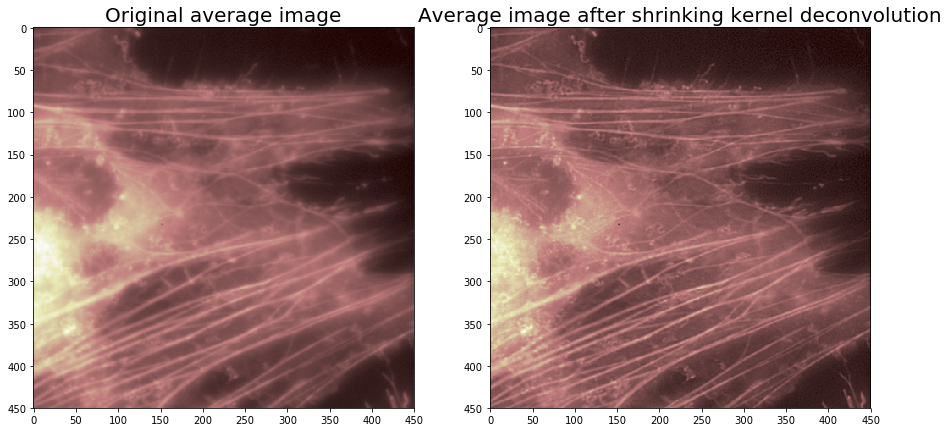

In [5]:
# show average image before and after the deconvolution
fig, axs = plt.subplots(1, 2, figsize=(15, 7))
axs[0].set_title('Original average image', fontsize=20)
axs[0].imshow(d.ave, cmap='pink')
axs[1].set_title('Average image after shrinking kernel deconvolution', fontsize=20)
axs[1].imshow(deconv_im, cmap='pink')
plt.show()

We can clearly see the enhancement in the deconvolution result. The following is a zoom-in panel to provide a closer look on the result:

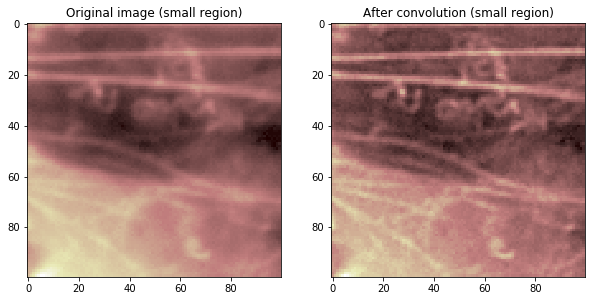

In [6]:
# Zoom into a small area
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].set_title('Original image (small region)')
axs[0].imshow(d.ave[100:200, 100:200], cmap='pink')

axs[1].set_title('After convolution (small region)')
axs[1].imshow(deconv_im[100:200, 100:200], cmap='pink')
plt.show() 

## 4. Use the <code>deconvsk.py</code> module for the DecovnSK analysis 

We can also perform the DeconvSK analysis by direclty importing the deconvsk.py function module.

This option is useful when one would like to perfrom DeconvSK as a standaloen process, which provides the flexibility for dissemination of the package. The relevant parameters is identical with the method integrated in the PysofiData class explained above in section 3: 

+ <code>est_psf</code>: the estimation of the PSF, which can be obtained from the simulations, estimated from the optical set-up, or calculated from the instrument calibration.
+ <code>input_im</code>: input image that needs to be deconvolved, format is a numpy.ndarray.
+ <code>deconv_lambda</code>: $\lambda$ exponent shwon in Eq. 1 (section 1). It is an empirical parameter with value set in between of 1 and 2. 
+ <code>deconv_iter</code>: number of iterations.

Below are the demonstration scripts.

In [7]:
# import the function module
from functions import deconvsk as deconv

# define the overal PSF:
deconv_psf2 = masks.gauss2d_mask((51, 51), 2)

# define parameters for deconvsk
deconv_lambda2 = 1.5
deconv_iter2 = 20

# load the time average of the tiff stack to be deconvolved
im2 = d.ave;

# perform the shrinking kernel deconvolution analysis
deconv_im2 = deconv.deconvsk(deconv_psf, im2, deconv_lambda, deconv_iter)


[=================== ] 100%

Now we can take a look at the results:

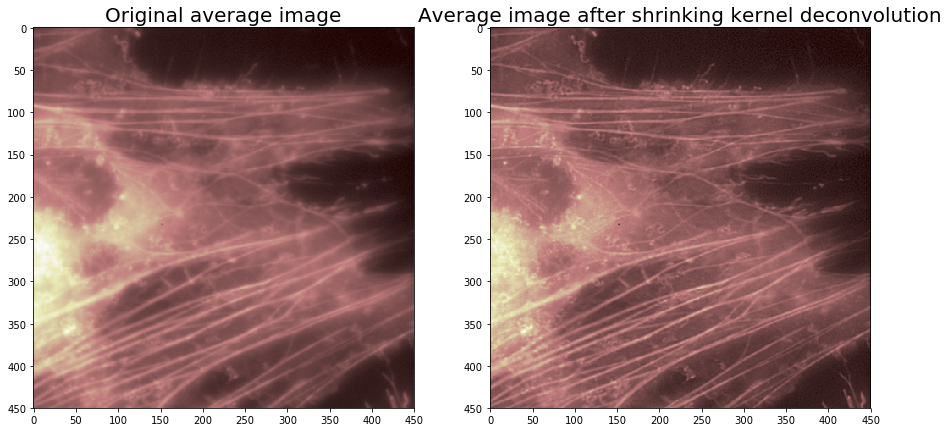

In [8]:
# show average image before and after the deconvolution
fig, axs = plt.subplots(1, 2, figsize=(15, 7))
axs[0].set_title('Original average image', fontsize=20)
axs[0].imshow(im2, cmap='pink')
axs[1].set_title('Average image after shrinking kernel deconvolution', fontsize=20)
axs[1].imshow(deconv_im2, cmap='pink')
plt.show()

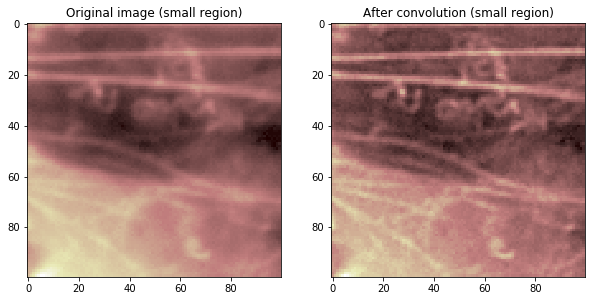

In [9]:
# Zoom into a small area
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].set_title('Original image (small region)')
axs[0].imshow(im2[100:200, 100:200], cmap='pink')

axs[1].set_title('After convolution (small region)')
axs[1].imshow(deconv_im2[100:200, 100:200], cmap='pink')
plt.show() 

## References
[1] Dertinger, Thomas, Ryan Colyer, Gopal Iyer, Shimon Weiss, and Jörg Enderlein. "Fast, background-free, 3D super-resolution optical fluctuation imaging (SOFI)." Proceedings of the National Academy of Sciences 106, no. 52 (2009): 22287-22292.